<a href="https://colab.research.google.com/github/Yuji-ONUKI/GCI2020_Winter/blob/main/Covid_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)
library(lubridate)
library(ggplot2)
install.packages('ggsci')
library(ggsci)
#library(reticulate)
#
graph_pass <- "Pictures/" #グラフを作成する場所の指定
#
#reticulate::source_python('download.py')
#source("daily/WHO1.R",encoding="utf8")
#source("daily/WHO2.R",encoding="utf8")
#source("daily/nhk.R",encoding="utf8")
#source("daily/KouseiRoudouSho.R",encoding="utf8")
#source("daily/vaccinations.R",encoding="utf8")
#source("before_tokyo_hassho_and_japan_20220208.R",encoding="utf8")
#source("daily/tokyo.R",encoding="utf8")

#png( paste(graph_pass,"00_suikei.png",sep=""))
#plot(g)
#dev.off()
#reticulate::source_python('../ExecExcelFromPython/ExcecExcelVBAFromPython.py')


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: 
Attaching package: ‘lubridate’


R[write to console]: The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/ggsci_2.9.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2873033 bytes (2.7 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to c

In [3]:
!mkdir Pictures

# download.py

In [4]:
import pandas as pd
import requests, zipfile
from io import StringIO
import io
who1 = requests.get("https://covid19.who.int/WHO-COVID-19-global-data.csv", stream=True)
who1c = pd.read_csv(io.BytesIO(who1.content),sep=",")
who1c.to_csv("WHO-COVID-19-global-data.csv", index=False)
who2 = requests.get("https://covid19.who.int/WHO-COVID-19-global-table-data.csv", stream=True)
who2c = pd.read_csv(io.BytesIO(who2.content),sep=",")
who2c.to_csv("WHO-COVID-19-global-table-data.csv", index=False)
#
tokyo = requests.get("https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients_2020.csv", stream=True)
tokyoc= pd.read_csv(io.BytesIO(tokyo.content),sep=",")
tokyoc.to_csv("130001_tokyo_covid19_patients_2020.csv", index=False)
#
tokyo = requests.get("https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients_2021.csv", stream=True)
tokyoc= pd.read_csv(io.BytesIO(tokyo.content),sep=",")
tokyoc.to_csv("130001_tokyo_covid19_patients_2021.csv", index=False)
#
tokyo = requests.get("https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients_2022.csv", stream=True)
tokyoc= pd.read_csv(io.BytesIO(tokyo.content),sep=",")
tokyoc.to_csv("130001_tokyo_covid19_patients_2022.csv", index=False)
#
tokyo = requests.get("https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients_2022-1.csv", stream=True)
tokyoc= pd.read_csv(io.BytesIO(tokyo.content),sep=",")
tokyoc.to_csv("130001_tokyo_covid19_patients_2022-1.csv", index=False)


# nhk_function.R

In [5]:
%%R
library(tidyverse)
#
# nhk_function
#
#
#              function
#
# function: avoid_png_error
#     png()保存するファイルが重複するエラーへの対応
#     file.remove()コマンドで削除した後でpng()する。
#     引数：png()へ渡す引数と同じ
#
avoid_png_error <- function( file_name , width = 1000, height = 1000){
  file.remove(file_name)
  png(file_name, width = 1000, height = 1000) # 描画デバイスを開く
}
#
# function: seven_diff
#     7日前ラグとの差分を返す
#     引数:df dataframe
#
seven_diff <- function(df,df_date=df$date){
  df1 <- data.frame(df)
  df_date2 <- data.frame(df_date)
  names(df1) <- c("x")
  #
  df2 <- df1 %>%
    mutate( hahaha=lag( x, 7 )) %>%
    mutate( dif7=x - hahaha ) %>%
    filter( !is.na(dif7 )) %>%
    select(dif7)
  #
  df_date_new <- df_date2[8:nrow(df_date2),]
  df3 <- data.frame( df_date_new, df2 )
  return(df3)
}
#
# function: add_lastData
#     dataframeにrow=列の最終データのみのlastData列を付け加える
#     引数:df dataframe
#     　　 row=2 dataframeの対象となる列番号
#
add_lastData <- function(df,row=2){
  df2 <- df %>%
    rowid_to_column("id") %>%
    mutate( lastData = ifelse(id==nrow(df),as.character(df[nrow(df),row]),"")) %>%
    select(-id)
  return(df2)
}
#
# function:graph_case
# 都道府県データ・感染者数グラフ　最終データのみ値表示
# 地方集計データのグラフ化
#
#   引数：meishou
#              data=nhk_case_chihoの場合
#              hokkaido,tohoku,kanto,shuto,aichiken,osakaken,fukuoka,okinawa,sonota
#　　　　　　　data=nhk_dataの場合;都道府県名
#
graph_case <- function(meishou,data=nhk_case_chiho){
  df <- data %>%
    filter(name %in% c(meishou)) %>%
    select(date,case)
  # 最後のデータのみ値表示
  df2 <- add_lastData(df,row=2)
  g <- ggplot(df2) + 
    geom_line(aes(x=ymd(date), y=case)) +
    geom_text(aes(x=ymd(date), y=case,label=lastData))
  return(g)
}
#
# function:graph_death_chiho
# 地方別死亡者数をグラフ描画
#   引数：chihomei
#         hokkaido,tohoku,kanto,shuto,aichiken,osakaken,fukuoka,okinawa,sonota
#
graph_death_chiho <- function(meishou,data=nhk_death_date_chiho){
  df <- data %>%
    filter(name %in% c(meishou)) %>%
    select(date,death)
  df2 <- add_lastData(df,row=2)
  g <- ggplot(df2) + 
    geom_line(aes(x=ymd(date), y=death)) +
    geom_text(aes(x=ymd(date), y=death, label=lastData))
  return(g)
}


# WHO1.R

In [6]:
%%R
library(tidyverse)
#
#source("daily/nhk_function.R")
#
#
#
#
# function graph_case_and_death
#   新規感染者数と死亡者数のグラフを描画
#   引数 cd:国コード
#
graph_case_and_death <- function(cd){
  df <- who_case_death %>% 
    filter(code %in% c(cd)) %>%
    mutate( death_ten = death * 10 ) %>%
    pivot_longer( c("case","death_ten"), names_to="kind" , values_to="value" )
  g <- ggplot(df) + 
    geom_line(aes(x=ymd(date), y=value, group =kind, color=kind)) +
    scale_color_brewer(palette = "Set1") 
  return(g)
}
#
# who.intよりファイルをダウンロード
#
#https://heavywatal.github.io/rstats/readr.html
who_csv <- read.csv(file="WHO-COVID-19-global-data.csv",fileEncoding="UTF-8-BOM")
who_case <- who_csv[,c(1,2,3,5)]
names(who_case) <- c("date","code","name","case")
#
who_cumulative <- who_csv[,c(1,2,3,6,8)]
names(who_cumulative) <- c("date","code","name","case","death")
#
who_case_death <- who_csv[,c(1,2,3,5,7)]
names(who_case_death) <- c("date","code","name","case","death")
#
# 感染者数と死亡者数のグラフ化
#
#   US
#
g <- graph_case_and_death("US") + labs(x="年月日", y="新規感染者・死亡者数（＊10）（人）", title="United States of America" )
avoid_png_error(paste(graph_pass,"14_USdeath.png"), width = 1000, height = 1000)  # 描画デバイスを開く
   plot(g)
dev.off()
#
#   India
#
g <- graph_case_and_death("IN")+ labs(x="年月日", y="新規感染者・死亡者数（＊10）（人）", title="India" )
avoid_png_error(paste(graph_pass,"14_2_Inddeath.png"), width = 1000, height = 1000)  # 描画デバイスを開く
   plot(g)
dev.off()
#
#  累計感染者数・累計死亡者数の散布グラフ描画
#　　US,India,Brasil,Mexico
#
df <- who_cumulative %>% filter(code %in% c("US","IN","BR","MX")) %>% 
                         mutate(max_date=min_rank(desc(date))) %>% 
                         mutate(country = ifelse( max_date == 1, code , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=case, y=death, group=name, color=name)) +
  geom_text(aes(x=case, y=death, label=country)) +
  labs(x="累計感染者数（人）", y="累計死亡者数（人）", title="主要国" ) +
  scale_color_brewer(palette = "Set1") 
avoid_png_error(paste(graph_pass,"18_散布図U.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
#    Russia,Peru,Indonesia,Colomba,Argentin,Iran,Iraq,Philipin
#
df <- who_cumulative %>% filter(code %in% c("RU","PE","ID","CO","AR","IR","IQ","PH"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(country = ifelse( max_date == 1, code , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=case, y=death, group=name, color=name)) +
  geom_text(aes(x=case, y=death, label=country)) +
  labs(x="累計感染者数（人）", y="累計死亡者数（人）", title="主要国" ) +
  scale_color_brewer(palette = "Set1") 
avoid_png_error(paste(graph_pass,"17_散布図I.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
#    European countries & canada
#
df <- who_cumulative %>% filter(code %in% c("GB","ES","IT","FR","DE","TR","SE","CZ","CA"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(country = ifelse( max_date == 1, code , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=case, y=death, group=name, color=name)) +
  geom_text(aes(x=case, y=death, label=country)) +
  labs(x="累計感染者数（人）", y="累計死亡者数（人）", title="European countries & canada" ) +
  scale_color_brewer(palette = "Set1") 
avoid_png_error(paste(graph_pass,"16_散布図E.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
#     Asian countries
#
df <- who_cumulative %>% filter(code %in% c("JP","CN","KR","AU","SG"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(country = ifelse( max_date == 1, code , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=case, y=death, group=name, color=name)) +
  geom_text(aes(x=case, y=death, label=country)) +
  labs(x="累計感染者数（人）", y="累計死亡者数（人）", title="Asian countries" ) +
  scale_color_brewer(palette = "Set1") 
avoid_png_error(paste(graph_pass,"15_散布図J.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
#
df <- who_case %>% filter(code %in% c("ID","US","BR","ES","RU","MX","DE","IR","FR"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(country = ifelse( max_date == 1, code , ""))
#
g <- ggplot(df) + 
  scale_y_log10() + 
  geom_line(aes(x=ymd(date), y=case, group=name, color=name)) +
  geom_text(aes(x=ymd(date), y=case, label=country)) +
  labs(x="年月日", y="新規感染者（人）", title="世界主要国" ) +
  scale_color_brewer(palette = "Set1") 
avoid_png_error(paste(graph_pass,"09_who.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
df <- who_case %>% filter(code %in% c("TR","GB","JP","IT","KR","SG"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(country = ifelse( max_date == 1, code , ""))
#
g <- ggplot(df) + 
  scale_y_log10() + 
  geom_line(aes(x=ymd(date), y=case, group=name, color=name)) +
  geom_text(aes(x=ymd(date), y=case, label=country)) +
  labs(x="年月日", y="新規感染者（人）", title="世界主要国" ) +
  scale_color_brewer(palette = "Set1") 
avoid_png_error(paste(graph_pass,"09_w0ho.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
df <- who_case %>% filter(code %in% c("ID","IR","IQ","JP","CN","KR","AU","SG"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(country = ifelse( max_date == 1, code , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=ymd(date), y=case, group=name, color=name)) +
  geom_text(aes(x=ymd(date), y=case,label=country)) +
  labs(x="年月日", y="新規感染者（人）", title="アジア主要国" ) +
  scale_color_brewer(palette = "Set1") 
avoid_png_error(paste(graph_pass,"10_whoJ.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
df <- who_case %>% filter(code %in% c("GB","FR","DE"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(country = ifelse( max_date == 1, code , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=ymd(date), y=case, group=name, color=name)) +
  geom_text(aes(x=ymd(date), y=case, label=country)) +
  labs(x="年月日", y="新規感染者（人）", title="英仏独" ) +
  scale_color_brewer(palette = "Set1") 
avoid_png_error(paste(graph_pass,"11_2_whoE.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
df <- who_case %>% filter(code %in% c("TR","RU","ES","IT","UA","SE"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(country = ifelse( max_date == 1, code , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=ymd(date), y=case, group=name, color=name)) +
  geom_text(aes(x=ymd(date), y=case, label=country)) +
  labs(x="年月日", y="新規感染者（人）", title="その他のヨーロッパ諸国" ) +
  scale_color_brewer(palette = "Set1") 
avoid_png_error(paste(graph_pass,"11_whoE.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
df <- who_case %>% filter(code %in% c("IN","US","BR"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(country = ifelse( max_date == 1, code , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=ymd(date), y=case, group=name, color=name)) +
  geom_text(aes(x=ymd(date), y=case, label=country)) +
  labs(x="年月日", y="新規感染者（人）", title="米・インド・ブラジル" ) +
  scale_color_brewer(palette = "Set1") 
avoid_png_error(paste(graph_pass,"12_whoU.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
df <- who_case %>% filter(code %in% c("AR","CO","MX","PE","CL","ZA","MA"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(country = ifelse( max_date == 1, code , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=ymd(date), y=case, group=name, color=name)) +
  geom_text(aes(x=ymd(date), y=case, label=country)) +
  labs(x="年月日", y="新規感染者（人）", title="中南米・アフリカ" ) +
  scale_color_brewer(palette = "Set1") 
avoid_png_error(paste(graph_pass,"13_dec.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#


png 
  2 


# WHO2.R

In [7]:
%%R
library(tidyverse)
library(ggplot2)
library(ggsci)
#
#source("daily/nhk_function.R")
#
#
#
#download.file(url="https://covid19.who.int/WHO-COVID-19-global-table-data.csv",destfile="WHO-COVID-19-global-table-data.csv")
who2 <- read.csv(file="WHO-COVID-19-global-table-data.csv",fileEncoding="UTF-8-BOM")
who3 <- data.frame(who2)
names(who3) <- c( "Name", "Region", "case_cumulative_total", "case_cumulative_total_per_100000_poputation", "case_newly_reported_in_last_7_days","case_newly_reported_in_last_7_days_per_100000_population","case_newly_reported_in_last_24_hours","death_cumulative_total","death_cumulative_total_per_100000_population","death_newly_reported_in_last_7_days","death_newly_reported_in_last_7_days_per_100000_population","death_newly_reported_in_last_24_hours")
#
who4 <- who3[c(2:40),c(1,7)]
#
g <- ggplot(who4, aes(x=Name,y=case_newly_reported_in_last_24_hours))
g <- g + geom_bar(stat="identity")
g <- g + theme(axis.text = element_text(angle = 60))
avoid_png_error(paste(graph_pass,"09_7 tops.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
who5 <- who3[c(2:nrow(who3)),c(1,7,12)]
who6 <-who5[order(who5$case_newly_reported_in_last_24_hours,decreasing = T),]
who7 <- who6[c(1:40),]
#
install.packages('gridExtra')
library(gridExtra)
avoid_png_error(paste(graph_pass,"09_6 table_1.png"), height=1000, width=1000)
p<-tableGrob(who7)
grid.arrange(p)
dev.off()




R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/gridExtra_2.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1062844 bytes (1.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

png 
  2 


# nhk.R

In [8]:
%%R
#
# 集計・日付処理・ggplot2(グラフ描画)のライブラリを使用
#
library(tidyverse)
library(lubridate)
library(ggplot2)
library(ggsci)
#
#source("daily/nhk_function.R")
#
#
#             作業実施
#
# nhk集計の日ごとの感染者数と死者数のデータをダウンロード
#
download.file(url="https://www3.nhk.or.jp/n-data/opendata/coronavirus/nhk_news_covid19_prefectures_daily_data.csv",destfile="nhk.csv")
#
nhk_csv <- read.csv(file="nhk.csv",fileEncoding="UTF-8-BOM")
write.csv(nhk_csv,"nhk1.csv", quote=FALSE, row.names=FALSE, na="" )
#
# nhk_data date,name,case,death 日ごとの感染者数と死者数
#
nhk_data <- nhk_csv[,c(1,3,4,6)]
names(nhk_data) <- c("date","name","case","death")
#
#　全国比率　新規感染者数
#
nhk_case <- nhk_csv[,c(1,3,4)]
names(nhk_case) <- c("date","name","case")
prop_case <- nhk_case %>%
  group_by(date) %>%
  mutate(japan = sum(case)) %>%
  mutate(prop = ifelse( japan !=0, round(case / japan, 3) * 100 ,0 )) %>% 
  arrange(date,name) %>%
  select(date,name,prop)
#
#　全国比率　死亡者数
#
nhk_death <- nhk_csv[,c(1,3,6)]
names(nhk_death) <- c("date","name","death")
prop_death <- nhk_death %>%
  group_by(date) %>%
  mutate(japan = sum(death)) %>%
  mutate(prop = ifelse( japan !=0, round(death / japan, 3) * 100 ,0 )) %>% 
  arrange(date,name) %>%
  select(date,name,prop)
#
# nhk_culmative date,name,case,death 日ごとの累積感染者数と累積死者数
#
#
nhk_cumulative <- nhk_csv[,c(1,3,5,7)]
names(nhk_cumulative) <- c("date","name","case","death")
#
# nhk_dataの２列目の都道府県名から5列目に地方分類名を追加
#
#
# 地方別集計
#
nhk_grouped_chiho <- nhk_data %>%
mutate(chiho = case_when(
name == "北海道" ~ "1_hokkaido",
name == "青森県" ~ "2_tohoku",
name =="秋田県" ~ "2_tohoku",
name =="岩手県" ~ "2_tohoku",
name =="宮城県" ~ "2_tohoku",
name =="山形県" ~ "2_tohoku",
name =="福島県" ~ "2_tohoku",
name =="茨城県" ~ "3_kanto",
name =="栃木県" ~ "3_kanto",
name =="群馬県" ~ "3_kanto",
name =="埼玉県" ~ "4_shuto",
name =="神奈川県" ~ "4_shuto",
name =="千葉県" ~ "4_shuto",
name =="東京都" ~ "4_shuto",
name =="新潟県" ~ "9_sonota",
name =="富山県" ~ "9_sonota",
name =="石川県" ~ "9_sonota",
name =="福井県" ~ "9_sonota",
name =="長野県" ~ "9_sonota",
name =="山梨県" ~ "9_sonota",
name =="静岡県" ~ "9_sonota",
name =="愛知県" ~ "5_aichi",
name =="岐阜県" ~ "5_aichi",
name =="三重県" ~ "5_aichi",
name =="滋賀県" ~ "9_sonota",
name =="和歌山県" ~ "9_sonota",
name =="奈良県" ~ "9_sonota",
name =="京都府" ~ "9_sonota",
name =="大阪府" ~ "6_osaka",
name =="兵庫県" ~ "6_osaka",
name =="岡山県" ~ "9_sonota",
name =="広島県" ~ "9_sonota",
name =="鳥取県" ~ "9_sonota",
name =="島根県" ~ "9_sonota",
name =="山口県" ~ "9_sonota",
name =="香川県" ~ "9_sonota",
name =="徳島県" ~ "9_sonota",
name =="愛媛県" ~ "9_sonota",
name =="高知県" ~ "9_sonota",
name =="福岡県" ~ "7_fukuoka",
name =="大分県" ~ "9_sonota",
name =="熊本県" ~ "9_sonota",
name =="佐賀県" ~ "9_sonota",
name =="長崎県" ~ "9_sonota",
name =="宮崎県" ~ "9_sonota",
name =="鹿児島県" ~ "9_sonota",
name =="沖縄県" ~ "8_okinawa")) %>% 
  select(date, case, death, chiho) %>% 
  group_by(date, chiho) #日付と地方名ごとに集計を指示
  
nhk_case_chiho <- nhk_grouped_chiho %>% 
                     summarize(cases=sum(case)) %>%   #   感染者数
                     select(date, chiho, cases) %>%
                     arrange(ymd(date))
names(nhk_case_chiho) <- c("date","name","case")

nhk_death_chiho <- nhk_grouped_chiho %>%
                     summarize(deaths=sum(death)) %>% #   死亡者数 
                     select(date, chiho, deaths) %>%
                     arrange(ymd(date))

names(nhk_death_chiho) <- c("date","name","death")
#
#　 全国比率
#
prop_case_chiho <- nhk_case_chiho %>%
  group_by(date) %>%
  mutate(japan = sum(case)) %>%
  mutate(prop = ifelse( japan !=0, round(case / japan, 3) * 100 ,0 )) %>% 
  arrange(date,as.factor(name)) %>%
  select(date,name,prop)
#
#　 全国比率
#
prop_death_chiho <- nhk_death_chiho %>%
  group_by(date) %>%
  mutate(japan = sum(death)) %>%
  mutate(prop = ifelse( japan !=0, round(death / japan, 3) * 100 ,0 )) %>% 
  arrange(date,name) %>%
  select(date,name,prop)
#
# 全国集計
#
nhk_grouped_date <- nhk_data %>% group_by(date)
#   感染者数
nhk_case_japan <- nhk_grouped_date %>% 
                  summarize(cases=sum(case)) %>% 
                  arrange(ymd(date))
names(nhk_case_japan) <- c( "date", "case")
#   死亡者数
nhk_death_japan <- nhk_grouped_date %>% 
                   summarize(deaths=sum(death)) %>% 
                   arrange(ymd(date))
names(nhk_death_japan) <- c( "date", "death")
#
# 宮城県感染者数グラフ
#
g <- graph_case(data=nhk_case,"宮城県") +
    labs(x="年月日", y="新規感染者（人）", title="宮城県" )
avoid_png_error(paste(graph_pass , "08_2_miyagi.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
#
#地方集計データのグラフ化
# 首都４都県
#
g <- graph_case(data=nhk_case_chiho,"4_shuto") + 
  labs(x="年月日", y="新規感染者（人）", title="首都４都県" )
avoid_png_error(paste(graph_pass , "08_5_shuto.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 大阪・兵庫
#
g <- graph_case(data=nhk_case_chiho,"6_osaka") + 
  labs(x="年月日", y="新規感染者（人）", title="大阪府＋兵庫県" )
avoid_png_error(paste(graph_pass , "08_4_osaka.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 北海道
#
g <- graph_case(data=nhk_case_chiho,"1_hokkaido") + 
  labs(x="年月日", y="新規感染者（人）", title="北海道" )
avoid_png_error(paste(graph_pass , "08_3_hokkaido.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 沖縄県
#
g <- graph_case(data=nhk_case_chiho,"8_okinawa") + 
  labs(x="年月日", y="新規感染者（人）", title="沖縄県" )
avoid_png_error(paste(graph_pass , "08_3_okinawa.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 愛知・岐阜・三重
#
g <- graph_case(data=nhk_case_chiho,"5_aichi") + 
  labs(x="年月日", y="新規感染者（人）", title="愛知岐阜三重" )
avoid_png_error(paste(graph_pass , "08_3_aichi.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 福岡県
#
g <- graph_case(data=nhk_case_chiho,"7_fukuoka") + 
  labs(x="年月日", y="新規感染者（人）", title="福岡県" )
avoid_png_error(paste(graph_pass , "08_3_fukuoka.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 東北
#
g <- graph_case(data=nhk_case_chiho,"2_tohoku") + 
  labs(x="年月日", y="新規感染者（人）", title="東北" )
avoid_png_error(paste(graph_pass , "08_3_tohoku.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 首都４都県以外の関東
#
g <- graph_case(data=nhk_case_chiho,"3_kanto") + 
  labs(x="年月日", y="新規感染者（人）", title="首都４都県以外の関東" )
avoid_png_error(paste(graph_pass , "08_3_kanto.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# その他の府県
#
g <- graph_case(data=nhk_case_chiho,"9_sonota") + labs(x="年月日", y="新規感染者（人）", title="その他府県" )
avoid_png_error(paste(graph_pass , "08_sonota.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 地方別グラフ
#
g <- ggplot(nhk_case_chiho)+ geom_area(mapping=aes(x=ymd(date),y=case, group=name, color=name, fill=name ), position="stack")  + 
  labs(x="年月日", y="新規感染者（人）", title="全国（地方別）" ) +
  scale_color_brewer(palette = "Set1") +
  scale_fill_brewer(palette = "Set1")

avoid_png_error(paste(graph_pass , "08_zenkoku.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 地方別感染者比率積み上げグラフ
#
g <- ggplot(prop_case_chiho)+ geom_area(mapping=aes(x=ymd(date),y=prop, group=name, color=name, fill=name ), position="stack")  + 
  labs(x="年月日", y="新規感染者比率(%)", title="全国（地方別）" ) +
  scale_color_brewer(palette = "Set1") +
  scale_fill_brewer(palette = "Set1")
avoid_png_error(paste(graph_pass , "08_zenkoku_prop.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 地方別死亡者比率積み上げグラフ
#
g <- ggplot(prop_death_chiho)+ geom_area(mapping=aes(x=ymd(date),y=prop, group=name, color=name, fill=name ), position="stack")  + 
  labs(x="年月日", y="死亡者比率（%）", title="全国（地方別）" ) +
  scale_color_brewer(palette = "Set1") +
  scale_fill_brewer(palette = "Set1")
avoid_png_error(paste(graph_pass , "08_zenkoku_death_prop.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 全国感染者数 グラフ
#
df <- add_lastData(nhk_case_japan, row=2)
g <- ggplot(df) + 
  geom_line(aes(x=ymd(date), y=case)) +
  geom_text(aes(x=ymd(date), y=case, label=lastData)) +
  labs(x="年月日", y="新規感染者（人）", title="全国" )
avoid_png_error(paste(graph_pass , "01_1 second.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()

df <- nhk_case_japan %>%
  mutate( no = row_number() ) %>%
  filter( no > 45 ) %>%
  arrange( desc(no)) %>%
  mutate( second = lag( case, n=90 )) %>%
  mutate( third = lag( case, n= 170)) %>%
  mutate( fourth = lag( case, n=298)) %>%
  mutate( fifth = lag( case, n=387))  %>%
  arrange( no ) %>%
  rename( first = case ) %>%
  mutate( first = ifelse( no > 91+45 ,NA, first ))  %>%
  mutate( second = ifelse( no > 116+45 ,NA, second ))  %>%
  mutate( third = ifelse( no < 41+45 | no > 207+45 ,NA, third ))  %>%
  mutate( fourth = ifelse( no < 82+45 | no > 183+45 ,NA, fourth ))  %>%
  mutate( fifth = ifelse( no < 94+45 ,NA, fifth ))  %>%
  filter( !is.na(first) | !is.na(second) | !is.na(third) | !is.na(fourth) | !is.na(fifth)) %>%
  pivot_longer( c( first, second, third, fourth, fifth ), names_to="kind", values_to = "case" )
#write.csv(df,"df.csv")
g <- ggplot(df) + 
  geom_line(aes(x=no, y=case, color = kind )) +
  labs(x="年月日", y="新規感染者（人）", title="全国" )

avoid_png_error(paste(graph_pass , "01_1_1 second.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 全国7日前差分
#
df <- seven_diff(nhk_case_japan$case,nhk_case_japan$date)
df2 <- add_lastData(df, row=2)
names(df2) <- c("date","case","lastData")
g <- ggplot(df2) + 
  geom_line(aes(x=ymd(date), y=case)) +
  geom_text(aes(x=ymd(date), y=case, label=lastData)) +
  labs(x="年月日", y="新規感染者（人）一週間前からの増減", title="全国" )
avoid_png_error(paste(graph_pass , "01_2 sbn.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 首都圏7日前差分
#
countryData <- subset(nhk_case_chiho,name=="4_shuto")
df <- seven_diff(countryData$case,countryData$date)
df2 <- add_lastData(df, row=2)
names(df2) <- c("date","case","lastData")
g <- ggplot(df2) + 
  geom_line(aes(x=ymd(date), y=case)) +
  geom_text(aes(x=ymd(date), y=case, label=lastData)) +
  labs(x="年月日", y="新規感染者（人）一週間前からの増減", title="首都４都県" )
avoid_png_error(paste(graph_pass , "01_2 sbn_shuto.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 東京都7日前差分
#
countryData <- subset(nhk_data,name=="東京都")
df <- seven_diff(countryData$case,countryData$date)
df2 <- add_lastData(df, row=2)
names(df2) <- c("date","case","lastData")
g <- ggplot(df2) + 
  geom_line(aes(x=ymd(date), y=case)) +
  geom_text(aes(x=ymd(date), y=case, label=lastData)) +
  labs(x="年月日", y="新規感染者（人）一週間前からの増減", title="東京都" )
avoid_png_error(paste(graph_pass , "01_2 sbn_tokyo.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 全国死亡者数　グラフ
#
df <- add_lastData(nhk_death_japan, row=2)
g <- ggplot(df) + 
  geom_line(aes(x=ymd(date), y=death)) +
  geom_text(aes(x=ymd(date), y=death, label=lastData)) +
  labs(x="年月日", y="新規死亡者（人）", title="全国" )
avoid_png_error(paste(graph_pass , "05_1_japanDeath.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
df <- nhk_death_japan %>%
  mutate( no = row_number() ) %>%
  filter( no > 45 ) %>%
  arrange( desc(no)) %>%
  mutate( second = lag( death, n=124 )) %>%
  mutate( third = lag( death, n= 268)) %>%
  arrange( no ) %>%
  rename( first = death ) %>%
  mutate( first = ifelse( no > 124+45 ,NA, first ))  %>%
  mutate( second = ifelse( no > 279+45 ,NA, second ))  %>%
  mutate( third = ifelse( no < 132+45 ,NA, third ))   %>%
  filter( !is.na(first) | !is.na(second) | !is.na(third) ) %>%
  pivot_longer( c( first, second, third ), names_to="kind", values_to = "case" )
#write.csv(df,"df.csv")
g <- ggplot(df) + 
  geom_line(aes(x=no, y=case, color = kind )) +
  labs(x="年月日", y="新規感染者（人）", title="全国" )

avoid_png_error(paste(graph_pass , "01_1_1 second.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 地方別死亡者数ー首都４都県
#
g <- graph_death_chiho("4_shuto",data=nhk_death_chiho) + 
  labs(x="年月日", y="死亡者（人）", title="首都４都県" )
avoid_png_error(paste(graph_pass , "05_japanDeath_shuto.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 地方別死亡者数ー大阪兵庫
#
g <- graph_death_chiho("6_osaka",data=nhk_death_chiho) + 
  labs(x="年月日", y="死亡者（人）", title="大阪兵庫" )
avoid_png_error(paste(graph_pass , "05_japanDeath_osaka.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 地方別死亡者数ー沖縄県
#
g <- graph_death_chiho("8_okinawa",data=nhk_death_chiho) + 
  labs(x="年月日", y="死亡者（人）", title="沖縄県" )
avoid_png_error(paste(graph_pass , "05_japanDeath_okinawa.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 累計感染者数・死亡者数　散布図
#
df <- nhk_cumulative %>% 
  filter(name %in% c("東京都","大阪府","北海道","兵庫県","愛知県","神奈川県","埼玉県","千葉県"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(area = ifelse( max_date == 1, name , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=case, y=death, group=name, color=name)) +
  geom_text(aes(x=case, y=death, label=area)) +
  labs(x="累計感染者数（人）", y="累計死亡者数（人）", title="都道府県別（１）" ) +
  scale_color_brewer(palette = "Dark2") 
avoid_png_error(paste(graph_pass , "23_散布図都道府県（１）.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()

#
# 累計感染者数・死亡者数　散布図
#
df <- nhk_cumulative %>% 
  filter(name %in% c("沖縄県","宮城県","京都府","滋賀県","福岡県","静岡県","新潟県","長野県"))%>% 
  mutate(max_date=min_rank(desc(date))) %>% 
  mutate(area = ifelse( max_date == 1, name , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=case, y=death, group=name, color=name)) +
  geom_text(aes(x=case, y=death, label=area)) +
  labs(x="累計感染者数（人）", y="累計死亡者数（人）", title="都道府県別（２）" ) +
  scale_color_brewer(palette = "Dark2") 
avoid_png_error(paste(graph_pass , "23_散布図都道府県（２）.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()


R[write to console]: trying URL 'https://www3.nhk.or.jp/n-data/opendata/coronavirus/nhk_news_covid19_prefectures_daily_data.csv'

R[write to console]: Content type 'application/x-excel'
R[write to console]:  length 1742697 bytes (1.7 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.
png 
  2 


# KouseiRoudouShou.R

In [9]:
%%R
#
# 集計・日付処理・ggplot2(グラフ描画)のライブラリを使用
#
library(tidyverse)
library(lubridate)
library(ggplot2)
library(ggsci)
#
#source("daily/nhk_function.R")
#
#
#             作業実施
#
# 厚生労働省集計の日ごとの入院・治療等を要する者のデータをダウンロード
#
download.file(url="https://covid19.mhlw.go.jp/public/opendata/requiring_inpatient_care_etc_daily.csv",destfile="nyuin.csv")
#
nyuin_csv <- read.csv(file="nyuin.csv",fileEncoding="UTF-8-BOM")
write.csv(nyuin_csv, "nyuin1.csv",quote=FALSE, row.names=FALSE, na="" )
names(nyuin_csv) <- c("Date","ALL")
#
# 厚生労働省集計の日ごとの重症者数のデータをダウンロード
#
download.file(url="https://covid19.mhlw.go.jp/public/opendata/severe_cases_daily.csv",destfile="severe_cases_daily.csv")
#
jushoshasu_csv <- read.csv(file="severe_cases_daily.csv",fileEncoding="UTF-8-BOM")
write.csv(jushoshasu_csv, "severe_cases_daily1.csv",quote=FALSE, row.names=FALSE, na="" )
#
# 全国の入院・治療を要する者
#
zenkoku_case <- nyuin_csv %>% 
  select( Date, ALL ) %>%
  rename( date=Date, nyuin=ALL )%>%
  mutate( max_date=min_rank(desc(ymd(date)))) %>% 
  mutate( val = ifelse( max_date == 1, nyuin , ""))

case_lag <- zenkoku_case %>%
  mutate( no = row_number() ) %>%
  rename( first = nyuin ) %>%
  arrange( desc(no)) %>%
  mutate( second = lag( first, n=96 )) %>%
  mutate( third = lag( first, n=186 )) %>%
  mutate( fourth = lag( first, n=302 )) %>%
  mutate( fifth = lag( first, n=404 )) %>%
  mutate( first = ifelse( no > 148, NA, first )) %>%
  mutate( second = ifelse( no < 54 | no > 165, NA, second )) %>%
  mutate( third = ifelse( no < 75 | no > 213, NA, third )) %>%
  mutate( fourth = ifelse( no < 99 | no > 195, NA, fourth )) %>%
  mutate( fifth = ifelse( no < 98, NA, fifth )) %>%
  filter( !is.na(first) | ! is.na(second) | ! is.na(third) | !is.na(fourth) | !is.na(fifth)) %>%
  arrange(no) %>%
  pivot_longer( c(first, second, third, fourth, fifth ), names_to="kind", values_to ="case2" )

#write.csv(case_lag,"case_lag.csv")
#
# グラフ
#
g <- ggplot(zenkoku_case)+ geom_line(mapping=aes(x=ymd(date),y=nyuin))  + 
  labs(x="年月日", y="入院・治療を要する者（人）", title="全国" ) +
  geom_text(aes(x=ymd(date), y=nyuin, label=val)) +
  scale_color_brewer(palette = "Set1") 

avoid_png_error(paste(graph_pass , "02_nyuin.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
g <- ggplot(case_lag)+ geom_line(mapping=aes(x=no,y=case2,color=kind))  + 
  labs(x="年月日", y="重症者数（人）", title="全国" ) +
  scale_color_brewer(palette = "Set1") 

avoid_png_error(paste(graph_pass , "02_2_nyuin.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 全国の重症者数
#
zenkoku_jusho <- jushoshasu_csv %>% 
  select( Date, ALL ) %>%
  mutate( max_date=min_rank(desc(ymd(Date)))) %>% 
  mutate( val = ifelse( max_date == 1, ALL , ""))

jusho_lag <- zenkoku_jusho %>%
  mutate( no = row_number() ) %>%
  filter( no > 82 ) %>%
  rename( first = ALL ) %>%
  arrange( desc(no) ) %>%
  mutate( second = lag( first, n = 61 )) %>%
  mutate( third = lag( first, n = 182 )) %>%
  mutate( fourth = lag( first, n = 293 )) %>%
  mutate( first = ifelse( no > 67+81, NA, first )) %>%
  mutate(second = ifelse( no < 8+81 | no > 176+81, NA, second )) %>%
  mutate( third = ifelse( no < 55+81 | no > 173+81, NA, third )) %>%
  mutate( fourth = ifelse( no < 65+81, NA, fourth )) %>%
  filter( !is.na(first) | ! is.na(second) | ! is.na(third) | !is.na(fourth) ) %>%
  arrange(no) %>%
  pivot_longer( c(first, second, third, fourth ), names_to="kind", values_to ="jusho2" )
#write.csv(jusho_lag,"jusho_lag.csv")
#
# グラフ
#
g <- ggplot(zenkoku_jusho)+ geom_line(mapping=aes(x=ymd(Date),y=ALL))  + 
  labs(x="年月日", y="重症者数（人）", title="全国" ) +
  scale_color_brewer(palette = "Set1") 

avoid_png_error(paste(graph_pass , "03_jusho.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
g <- ggplot(jusho_lag)+ geom_line(mapping=aes(x = no,y=jusho2,color=kind))  + 
  labs(x="年月日", y="重症者数（人）", title="全国" ) +
  scale_color_brewer(palette = "Set1") 

avoid_png_error(paste(graph_pass , "03_2jusho.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()
#
# 東京、大阪、沖縄県の重症者数
#
df <- jushoshasu_csv %>%
  select( Date, Osaka, Tokyo, Kanagawa, Saitama, Aichi, Okinawa, Fukuoka, Chiba ) %>%
  pivot_longer(cols = c("Osaka","Tokyo","Kanagawa","Saitama","Aichi","Okinawa","Fukuoka","Chiba"),
               names_to= "name", values_to = "jusho") %>%
  rename(date=Date) %>%
  mutate(max_date=min_rank(desc(ymd(date)))) %>% 
  mutate(ken = ifelse( max_date == 1, name , ""))
#
g <- ggplot(df) + 
  geom_line(aes(x=ymd(date), y=jusho, group=name, color=name)) +
  geom_text(aes(x=ymd(date), y=jusho,label=ken)) +
  labs(x="年月日", y="重症者数（人）", title="主な都府県" ) +
  scale_color_brewer(palette = "Dark2") 
avoid_png_error(paste(graph_pass,"04_jusho_ken.png"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()


R[write to console]: trying URL 'https://covid19.mhlw.go.jp/public/opendata/requiring_inpatient_care_etc_daily.csv'

R[write to console]: Content type 'application/octet-stream'
R[write to console]:  length 427884 bytes (417 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to 

png 
  2 


# vaccinations.R


In [10]:
%%R
#
# 集計・日付処理・ggplot2(グラフ描画)のライブラリを使用
#
library(tidyverse)
library(lubridate)
library(ggplot2)
library(ggsci)
#
library(gridExtra)
library(grid)
library(gtable)
#
#
#              function add_table_title
#
add_table_title <- function( ta = t1 , t = title ){
  title <- textGrob( t, gp = gpar(fontsize = 20) )
  table_contents <- tableGrob( ta )
  table_product <- gtable_add_rows(
    table_contents, 
    heights = grobHeight(title) + padding,
    pos = 0)
  #
  table_product <- gtable_add_grob(
    table_product, 
    title, 
    1, 1, 1, ncol(table_product))
  #
  return( table_product )
}
#
# function: avoid_png_error
#     png()保存するファイルが重複するエラーへの対応
#     file.remove()コマンドで削除した後でpng()する。
#     引数：png()へ渡す引数と同じ
#
avoid_png_error <- function( file_name , width = 1000, height = 1000){
  file.remove(file_name)
  png(file_name, width = 1000, height = 1000) # 描画デバイスを開く
}
#
#graph_pass <- "C:/Users/Onuki/Pictures/" #グラフを作成する場所の指定
#
padding <- unit(5,"mm")
#
#             作業実施
#
# Our World in data サイトよりワクチンのデータをダウンロード
#
download.file(url="https://github.com/owid/covid-19-data/raw/master/public/data/vaccinations/vaccinations.csv",destfile="vaccinations.csv")
#
vaccinations_csv <- read.csv(file="vaccinations.csv",fileEncoding="UTF-8-BOM")
#colnames <- names(vaccinations_csv)
#[1] "location"                            "iso_code"                           
#[3] "date"                                "total_vaccinations"                 
#[5] "people_vaccinated"                   "people_fully_vaccinated"            
#[7] "total_boosters"                      "daily_vaccinations_raw"             
#[9] "daily_vaccinations"                  "total_vaccinations_per_hundred"     
#[11] "people_vaccinated_per_hundred"       "people_fully_vaccinated_per_hundred"
#[13] "total_boosters_per_hundred"          "daily_vaccinations_per_million"     
df <- vaccinations_csv %>%
  select( location, iso_code, date, total_vaccinations, people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred, total_boosters_per_hundred) %>%
  rename( name=location, code=iso_code , total=total_vaccinations, percent=people_vaccinated_per_hundred, fully_percent=people_fully_vaccinated_per_hundred, boostered=total_boosters_per_hundred)

df_percent <- df %>% select (name,date,total, code,percent) %>%
                     filter( !is.na(percent)) %>%
                     group_by( code ) %>%
                     mutate(max_date=min_rank(desc(date))) %>% 
                     filter( max_date == 1) %>%
                     select( -max_date ) %>%
                     arrange( desc(percent)) %>% 
                     filter( total > 200000 ) %>%
                     filter( nchar(code) == 3 ) %>%
                     ungroup( code ) %>%
                     mutate( ranking = min_rank(desc(percent))) %>%
                     select( ranking, name, percent )

df_percent_40 <- df_percent %>% filter( ranking < 41 )

df_percent_80 <- df_percent %>% filter( ranking > 40 ) %>%
                                filter( ranking < 81 )
df_percent_120 <- df_percent %>% filter( ranking > 80 ) %>%
                                filter( ranking < 121 )
df_percent_bottom <- df_percent %>% filter( ranking > 120 ) 

table <- add_table_title( ta = df_percent_40 ,
                 t = "ワクチン接種率top40" )
#
avoid_png_error(paste(graph_pass , "20_1ワクチン接種率top40.png"), width = 1000, height = 1000)  # 描画デバイスを開く
grid.arrange(table)
dev.off()

p　<-　add_table_title( ta = df_percent_80 ,
                      t = "ワクチン接種率top80" )
#
avoid_png_error(paste(graph_pass , "20_2ワクチン接種率top80.png"), width = 1000, height = 1000)  # 描画デバイスを開く
grid.arrange(p)
dev.off()

p　<-　add_table_title( ta = df_percent_120,
                      t = "ワクチン接種率top120" )
#
avoid_png_error(paste(graph_pass , "20_3ワクチン接種率top120.png"), width = 1000, height = 1000)  # 描画デバイスを開く
grid.arrange(p)
dev.off()

p　<-　add_table_title( ta = df_percent_bottom,
               t = "ワクチン接種率bottom" )
#
avoid_png_error(paste(graph_pass , "20_4ワクチン接種率bottom.png"), width = 1000, height = 1000)  # 描画デバイスを開く
grid.arrange(p)
dev.off()
#
#  2回接種
#
df_fully_percent <- df %>% select (name,date,total, code,　fully_percent) %>%
　rename( percent = fully_percent ) %>%
  filter( !is.na(percent)) %>%
  group_by( code ) %>%
  mutate(max_date=min_rank(desc(date))) %>% 
  filter( max_date == 1) %>%
  select( -max_date ) %>%
  arrange( desc(percent)) %>% 
  filter( total > 200000 ) %>%
  filter( nchar(code) == 3 ) %>%
  ungroup( code ) %>%
  mutate( ranking = min_rank(desc(percent))) %>%
  select( ranking, name, percent )

df_fully_percent_40 <- df_fully_percent %>% filter( ranking < 41 )

df_fully_percent_80 <- df_fully_percent %>% filter( ranking > 40 ) %>%
  filter( ranking < 81 )
df_fully_percent_120 <- df_fully_percent %>% filter( ranking > 80 ) %>%
  filter( ranking < 121 )
df_fully_percent_bottom <- df_fully_percent %>% filter( ranking > 120 ) 

p　<-　add_table_title( ta = df_fully_percent_40,
               t = "ワクチン接種率2回top40" )
#
avoid_png_error(paste(graph_pass , "20_5ワクチン接種率2回top40.png"), width = 1000, height = 1000)  # 描画デバイスを開く
grid.arrange(p)
dev.off()

p　<-　add_table_title( ta = df_fully_percent_80,
               t = "ワクチン接種率2回top80" )
#)
avoid_png_error(paste(graph_pass , "20_6ワクチン接種率2回top80.png"), width = 1000, height = 1000)  # 描画デバイスを開く
grid.arrange(p)
dev.off()

p　<-　add_table_title( ta = df_fully_percent_120,
               t = "ワクチン接種率２回top120" )
#)
avoid_png_error(paste(graph_pass , "20_7ワクチン接種率２回top120.png"), width = 1000, height = 1000)  # 描画デバイスを開く
grid.arrange(p)
dev.off()

p　<-　add_table_title( ta = df_fully_percent_bottom,
               t = "ワクチン接種率２回bottom" )
#)
avoid_png_error(paste(graph_pass , "20_8ワクチン接種率２回bottom.png"), width = 1000, height = 1000)  # 描画デバイスを開く
grid.arrange(p)
dev.off()
#
#  ブースター接種
#
df_boostered_percent <- df %>% select (name,date,total, code,　boostered) %>%
  rename( percent = boostered ) %>%
  filter( !is.na(percent)) %>%
  group_by( code ) %>%
  mutate(max_date=min_rank(desc(date))) %>% 
  filter( max_date == 1) %>%
  select( -max_date ) %>%
  arrange( desc(percent)) %>% 
  filter( total > 200000 ) %>%
  filter( nchar(code) == 3 ) %>%
  ungroup( code ) %>%
  mutate( ranking = min_rank(desc(percent))) %>%
  select( ranking, name, percent )

df_boostered_percent_40 <- df_boostered_percent %>% filter( ranking < 41 )

df_boostered_percent_80 <- df_boostered_percent %>% filter( ranking > 40 ) %>%
  filter( ranking < 81 )
df_boostered_percent_120 <- df_boostered_percent %>% filter( ranking > 80 ) %>%
  filter( ranking < 121 )
df_boostered_percent_bottom <- df_boostered_percent %>% filter( ranking > 120 ) 

library(gridExtra)
p　<-　　add_table_title( ta = df_boostered_percent_40,
               t = "ワクチン接種率3回top40" )
#
avoid_png_error(paste(graph_pass , "20_90ワクチン接種率3回top40.png"), width = 1000, height = 1000)  # 描画デバイスを開く
grid.arrange(p)
dev.off()

#p　<-　tableGrob(df_boostered_percent_80)
#avoid_png_error(paste(graph_pass , "20_91ワクチン接種率3回top80.png"), width = 1000, height = 1000)  # 描画デバイスを開く
#grid.arrange(p)
#dev.off()

#p　<-　tableGrob(df_boostered_percent_120)
#avoid_png_error(paste(graph_pass , "20_92ワクチン接種率3回top120.png"), width = 1000, height = 1000)  # 描画デバイスを開く
#grid.arrange(p)
#dev.off()

#p　<-　tableGrob(df_boostered_percent_bottom)
#avoid_png_error(paste(graph_pass , "20_93ワクチン接種率3回bottom.png"), width = 1000, height = 1000)  # 描画デバイスを開く
#grid.arrange(p)
#dev.off()

#iso_code <- vaccinations_csv %>%
#  select( location, iso_code) %>%
#  group_by( iso_code ) %>%
#  distinct( location )
#write.csv(iso_code,"isocode.csv")
#		location	iso_code
#	1	Afghanistan	AFG
#	2	Africa	OWID_AFR
#	3	Albania	ALB
#	4	Algeria	DZA
#	5	Andorra	AND
#	6	Angola	AGO
#	7	Anguilla	AIA
#	8	Antigua and Barbuda	ATG
#	9	Argentina	ARG
#	10	Armenia	ARM
#	11	Aruba	ABW
#	12	Asia	OWID_ASI
#	13	Australia	AUS
#	14	Austria	AUT
#	15	Azerbaijan	AZE
#	16	Bahamas	BHS
#	17	Bahrain	BHR
#	18	Bangladesh	BGD
#	19	Barbados	BRB
#	20	Belarus	BLR
#	21	Belgium	BEL
#	22	Belize	BLZ
#	23	Benin	BEN
#	24	Bermuda	BMU
#	25	Bhutan	BTN
#	26	Bolivia	BOL
#	27	Bonaire Sint Eustatius and Saba	BES
#	28	Bosnia and Herzegovina	BIH
#	29	Botswana	BWA
#	30	Brazil	BRA
#	31	British Virgin Islands	VGB
#	32	Brunei	BRN
#	33	Bulgaria	BGR
#	34	Burkina Faso	BFA
#	35	Cambodia	KHM
#	36	Cameroon	CMR
#	37	Canada	CAN
#	38	Cape Verde	CPV
#	39	Cayman Islands	CYM
#	40	Central African Republic	CAF
#	41	Chad	TCD
#	42	Chile	CHL
#	43	China	CHN
#	44	Colombia	COL
#	45	Comoros	COM
#	46	Congo	COG
#	47	Cook Islands	COK
#	48	Costa Rica	CRI
#	49	Cote d'Ivoire	CIV
#	50	Croatia	HRV
#	51	Cuba	CUB
#	52	Curacao	CUW
#	53	Cyprus	CYP
#	54	Czechia	CZE
#	55	Democratic Republic of Congo	COD
#	56	Denmark	DNK
#	57	Djibouti	DJI
#	58	Dominica	DMA
#	59	Dominican Republic	DOM
#	60	Ecuador	ECU
#	61	Egypt	EGY
#	62	El Salvador	SLV
#	63	England	OWID_ENG
#	64	Equatorial Guinea	GNQ
#	65	Estonia	EST
#	66	Eswatini	SWZ
#	67	Ethiopia	ETH
#	68	Europe	OWID_EUR
#	69	European Union	OWID_EUN
#	70	Faeroe Islands	FRO
#	71	Falkland Islands	FLK
#	72	Fiji	FJI
#	73	Finland	FIN
#	74	France	FRA
#	75	French Polynesia	PYF
#	76	Gabon	GAB
#	77	Gambia	GMB
#	78	Georgia	GEO
#	79	Germany	DEU
#	80	Ghana	GHA
#	81	Gibraltar	GIB
#	82	Greece	GRC
#	83	Greenland	GRL
#	84	Grenada	GRD
#	85	Guatemala	GTM
#	86	Guernsey	GGY
#	87	Guinea	GIN
#	88	Guinea-Bissau	GNB
#	89	Guyana	GUY
#	90	Haiti	HTI
#	91	High income	OWID_HIC
#	92	Honduras	HND
#	93	Hong Kong	HKG
#	94	Hungary	HUN
#	95	Iceland	ISL
#	96	India	IND
#	97	Indonesia	IDN
#	98	Iran	IRN
#	99	Iraq	IRQ
#	100	Ireland	IRL
#	101	Isle of Man	IMN
#	102	Israel	ISR
#	103	Italy	ITA
#	104	Jamaica	JAM
#	105	Japan	JPN
#	106	Jersey	JEY
#	107	Jordan	JOR
#	108	Kazakhstan	KAZ
#	109	Kenya	KEN
#	110	Kiribati	KIR
#	111	Kosovo	OWID_KOS
#	112	Kuwait	KWT
#	113	Kyrgyzstan	KGZ
#	114	Laos	LAO
#	115	Latvia	LVA
#	116	Lebanon	LBN
#	117	Lesotho	LSO
#	118	Liberia	LBR
#	119	Libya	LBY
#	120	Liechtenstein	LIE
#	121	Lithuania	LTU
#	122	Low income	OWID_LIC
#	123	Lower middle income	OWID_LMC
#	124	Luxembourg	LUX
#	125	Macao	MAC
#	126	Madagascar	MDG
#	127	Malawi	MWI
#	128	Malaysia	MYS
#	129	Maldives	MDV
#	130	Mali	MLI
#	131	Malta	MLT
#	132	Mauritania	MRT
#	133	Mauritius	MUS
#	134	Mexico	MEX
#	135	Moldova	MDA
#	136	Monaco	MCO
#	137	Mongolia	MNG
#	138	Montenegro	MNE
#	139	Montserrat	MSR
#	140	Morocco	MAR
#	141	Mozambique	MOZ
#	142	Myanmar	MMR
#	143	Namibia	NAM
#	144	Nauru	NRU
#	145	Nepal	NPL
#	146	Netherlands	NLD
#	147	New Caledonia	NCL
#	148	New Zealand	NZL
#	149	Nicaragua	NIC
#	150	Niger	NER
#	151	Nigeria	NGA
#	152	Niue	NIU
#	153	North America	OWID_NAM
#	154	North Macedonia	MKD
#	155	Northern Cyprus	OWID_CYN
#	156	Northern Ireland	OWID_NIR
#	157	Norway	NOR
#	158	Oceania	OWID_OCE
#	159	Oman	OMN
#	160	Pakistan	PAK
#	161	Palestine	PSE
#	162	Panama	PAN
#	163	Papua New Guinea	PNG
#	164	Paraguay	PRY
#	165	Peru	PER
#	166	Philippines	PHL
#	167	Pitcairn	PCN
#	168	Poland	POL
#	169	Portugal	PRT
#	170	Qatar	QAT
#	171	Romania	ROU
#	172	Russia	RUS
#	173	Rwanda	RWA
#	174	Saint Helena	SHN
#	175	Saint Kitts and Nevis	KNA
#	176	Saint Lucia	LCA
#	177	Saint Vincent and the Grenadines	VCT
#	178	Samoa	WSM
#	179	San Marino	SMR
#	180	Sao Tome and Principe	STP
#	181	Saudi Arabia	SAU
#	182	Scotland	OWID_SCT
#	183	Senegal	SEN
#	184	Serbia	SRB
#	185	Seychelles	SYC
#	186	Sierra Leone	SLE
#	187	Singapore	SGP
#	188	Sint Maarten (Dutch part)	SXM
#	189	Slovakia	SVK
#	190	Slovenia	SVN
#	191	Solomon Islands	SLB
#	192	Somalia	SOM
#	193	South Africa	ZAF
#	194	South America	OWID_SAM
#	195	South Korea	KOR
#	196	South Sudan	SSD
#	197	Spain	ESP
#	198	Sri Lanka	LKA
#	199	Sudan	SDN
#	200	Suriname	SUR
#	201	Sweden	SWE
#	202	Switzerland	CHE
#	203	Syria	SYR
#	204	Taiwan	TWN
#	205	Tajikistan	TJK
#	206	Tanzania	TZA
#	207	Thailand	THA
#	208	Timor	TLS
#	209	Togo	TGO
#	210	Tokelau	TKL
#	211	Tonga	TON
#	212	Trinidad and Tobago	TTO
#	213	Tunisia	TUN
#	214	Turkey	TUR
#	215	Turkmenistan	TKM
#	216	Turks and Caicos Islands	TCA
#	217	Tuvalu	TUV
#	218	Uganda	UGA
#	219	Ukraine	UKR
#	220	United Arab Emirates	ARE
#	221	United Kingdom	GBR
#	222	United States	USA
#	223	Upper middle income	OWID_UMC
#	224	Uruguay	URY
#	225	Uzbekistan	UZB
#	226	Vanuatu	VUT
#	227	Venezuela	VEN
#	228	Vietnam	VNM
#	229	Wales	OWID_WLS
#	230	Wallis and Futuna	WLF
#	231	World	OWID_WRL
#	232	Yemen	YEM
#	233	Zambia	ZMB
#	234	Zimbabwe	ZWE


R[write to console]: trying URL 'https://github.com/owid/covid-19-data/raw/master/public/data/vaccinations/vaccinations.csv'

R[write to console]: Content type 'text/plain; charset=utf-8'
R[write to console]:  length 8313346 bytes (7.9 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


png 
  2 


# tougou.R

In [11]:
import pandas as pd
tougou_case_url = 'https://drive.google.com/uc?id=1wjbh2Cby3lSlRNG8mGnX8h7ref04wxMv'
tougou_case = pd.read_csv(tougou_case_url)
tougou_case.to_csv('tougou_case.csv',index=False)

# before_tokyo_hassho_and_japan_20220208.R

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/remotes_2.4.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 152540 bytes (148 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[writ

* checking for file ‘/tmp/RtmpMpcLvP/remotes3d5d491d3c/lawine90-elseR-3411b45/DESCRIPTION’ ... OK
* preparing ‘elseR’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘elseR_0.1.0.tar.gz’



R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



`summarise()` has grouped output by 'kohyo'. You can override using the
`.groups` argument.


R[write to console]: trying URL 'https://www3.nhk.or.jp/n-data/opendata/coronavirus/nhk_news_covid19_prefectures_daily_data.csv'

R[write to console]: Content type 'application/x-excel'
R[write to console]:  length 1742697 bytes (1.7 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

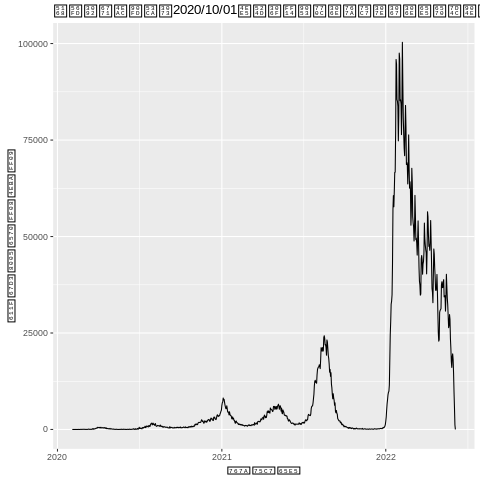

In [13]:
%%R
###################
#
# 東京都(2020/10/01以降)及び
# 4道県（2020/10/01以前）オープンデータによる
# 全国発症日別感染者数推計
#
# 使用方法
#
# 全国ではなく特定都道府県にしたい場合は　
#  #全国集計の２行を次のコードに入れ替える
#   神奈川県の例
#
#  filter( name == "神奈川県" ) %>%
#
# 事前の手作業
#
# 兵庫県のデータ準備
# https://web.pref.hyogo.lg.jp/kk03/corona_hasseijyokyo.html
# excelの書式指定で西暦年月日にして指定したCSVに保存
#
#
# 宮城県のデータ準備
# url_link = paste( "https://www.pref.miyagi.jp/pdf/covid19/",
#                  "m-covid-kanja.xls" , sep = "" )
#
# download.file( url = url_link ,
#               destfile = "宮城県m-covid-kanja.xls" )
#
#　２ページ目をmiyagi_file_nameで指定したCSVに保存
#
install.packages("remotes")
remotes::install_github("lawine90/elseR")
#
# 集計・日付処理・ggplot2(グラフ描画)のライブラリを使用
#
library(tidyverse)
library(lubridate)
library(rvest)
library(elseR)   # elseR は上の２行によりインストールする
library(stringr)
library(ggplot2)
###################
#
# 使用するファイル
#
#    入力
#
# NHKデータファイル
#
nhk_file_name = "nhk.csv"
#
# 都道県データファイル
#
#tokyo_file_name = "tokyo.csv"
#hokkaido_file_name = "../hokkaido.csv"
#okinawa_file_name = "okinawa_kohyobi_nashi.csv"
#miyagi_file_name = "../宮城県m-covid-kanja.csv"
#hyogo_file_name = "../兵庫県corona-kanjajokyou.csv"
tougou_case <- read.csv("tougou_case.csv", header = T ) %>%
	mutate( kohyo =ymd(kohyo))
#
#
# 以下2020/10/01公表分以降の推計
#
# 東京都公表の日ごとの感染者数のデータをダウンロード
#
#
#
tokyo_file_name = "130001_tokyo_covid19_patients_2020.csv"

ari_nashi_tomo_2020 <- 
 read.csv(file = tokyo_file_name, skip = 1, header=F,
           fileEncoding = "UTF-8-BOM"  ) %>%
  select( c( 1, 5, 6, 7, 8, 9, 10, 11, 15, 17 ))  %>%
  rename( no= V1, kohyo= V5, hassho= V6, kakutei= V7, kyojuchi = V8, age = V9, sex = V10, oc = V11, kansen = V15, taiin = V17 ) 

tokyo_file_name = "130001_tokyo_covid19_patients_2021.csv"

ari_nashi_tomo_2021 <- 
 read.csv(file = tokyo_file_name, skip = 1, header=F,
           fileEncoding = "UTF-8-BOM"  ) %>%
  select( c( 1, 5, 6, 7, 8, 9, 10, 11, 15, 17 ))  %>%
  rename( no= V1, kohyo= V5, hassho= V6, kakutei= V7, kyojuchi = V8, age = V9, sex = V10, oc = V11, kansen = V15, taiin = V17 ) 

tokyo_file_name = "130001_tokyo_covid19_patients_2022.csv"

ari_nashi_tomo_2022 <- 
 read.csv(file = tokyo_file_name, skip = 1, header=F,
           fileEncoding = "UTF-8-BOM"  ) %>%
  select( c( 1, 5, 6, 7, 8, 9, 10, 11, 15, 17 ))  %>%
  rename( no= V1, kohyo= V5, hassho= V6, kakutei= V7, kyojuchi = V8, age = V9, sex = V10, oc = V11, kansen = V15, taiin = V17 ) 

tokyo_file_name = "130001_tokyo_covid19_patients_2022-1.csv"

ari_nashi_tomo_2022_1 <- 
 read.csv(file = tokyo_file_name, skip = 1, header=F,
           fileEncoding = "UTF-8-BOM"  ) %>%
  select( c( 1, 5, 6, 7, 8, 9, 10, 11, 15, 17 ))  %>%
  rename( no= V1, kohyo= V5, hassho= V6, kakutei= V7, kyojuchi = V8, age = V9, sex = V10, oc = V11, kansen = V15, taiin = V17 ) 

tokyo_case <- rbind(
	ari_nashi_tomo_2020,
	ari_nashi_tomo_2021,
	ari_nashi_tomo_2022,
  ari_nashi_tomo_2022_1)

write.csv(tokyo_case,"tokyo.csv", row.names = FALSE )

tokyo_case <- rbind(
	ari_nashi_tomo_2020,
	ari_nashi_tomo_2021,
	ari_nashi_tomo_2022,
  ari_nashi_tomo_2022_1) %>%
  select( kohyo, hassho, kakutei) %>%
  filter( !is.na( kakutei ) ) %>%          # 確定日のあるデータ(2020/10/01-)
  filter( kakutei != "" )  %>%　　　     
#  filter( !is.na( hassho )) %>%            # 発症日有りのデータ
  filter( hassho != "" ) %>%             
  mutate( kohyo = ymd( kohyo ) ) %>%
  mutate( hassho = ymd( hassho ) ) %>%
  mutate( days = kohyo - hassho )  %>%
  select( kohyo, days ) %>%
  group_by( kohyo, days ) %>%
  summarise( case = n()) %>%
  ungroup( kohyo, days )
#
tougou_case <- tougou_case %>% 
  rbind( tokyo_case ) %>%
  arrange( kohyo )
#
# NHK集計の日ごとの感染者数のデータをダウンロード
#
url_link = paste("https://www3.nhk.or.jp/n-data/opendata/coronavirus/",
                 "nhk_news_covid19_prefectures_daily_data.csv", sep = "")
#
download.file(
  url = url_link,
  destfile = nhk_file_name )
#
zenkoku_case <- read.csv( file = nhk_file_name, 
                            fileEncoding = "UTF-8-BOM" ,
                            header = F , skip = 1 ) %>%
  select( c(1,3,4) )  %>%
  rename( kohyo = V1, name = V3, case = V4 ) %>% 
  mutate( kohyo = ymd( kohyo )) %>% 
  #
  group_by( kohyo ) %>%                        # 全国集計
  summarize( case = sum ( case ) ) %>%         # 全国集計
  #
  # 全国に変わって神奈川県を対象とする場合
  #
  #  filter( name == "神奈川県" ) %>%
  #
  group_by( kohyo ) %>%
  summarize( case = sum( case )) %>% 
  arrange( kohyo ) %>%
  filter( kohyo > ymd( "2020/02/18" ))
#
# 発症日有りのデータについて公表日ごとの感染者数を集計
#
ratio <- tougou_case %>%　
  group_by( kohyo ) %>%                                   # 発症日ありの公表日毎
  summarise( tky_case = sum(　case　) ) %>%
　merge( zenkoku_case, by = "kohyo"　)  %>%
  mutate( hiritu = case/tky_case )  %>%　　　　　　# 比率
  select( kohyo, hiritu )
#
# 発症日無しのデータの発症日ごとの感染者数の推計
#
estimate_1st_step <- tougou_case %>%
  pivot_wider( names_from = days, values_from = case ) %>%
　merge( ratio, by="kohyo") %>% 
  pivot_longer( c(-kohyo, -hiritu), names_to = "days", values_to = "case")  %>%
  filter( !is.na( case ) )  %>%
  mutate( suikei = round(　case * hiritu, 0) )
#
estimate_mode <- estimate_1st_step %>%
  group_by( kohyo ) %>%
  mutate( rownumber = row_number( desc( case ) )) %>%
  ungroup() %>%
  filter( rownumber == 1 ) %>%
  select( kohyo, days )
#
# 四捨五入による公表日別発症者数の推計値との誤差を補正。最初の最頻値に加減算
#
result <- estimate_1st_step %>%
  group_by( kohyo ) %>%
  mutate( sum_estimate = sum(suikei) ) %>%
  distinct( kohyo, sum_estimate ) %>%
  merge( zenkoku_case, by="kohyo", all = T ) %>%
  mutate( diff = case - sum_estimate ) %>%
  select( -sum_estimate, -case ) %>%
  merge( estimate_mode, by="kohyo", all =T ) %>%
  merge( estimate_1st_step, by=c("kohyo","days"), all= T ) %>%
  mutate( suikei = ifelse( !is.na(diff), suikei + diff, suikei ) ) %>%
  filter( !is.na(suikei) ) %>%
  select( kohyo, days, suikei) %>%
  mutate( hassho = kohyo - days(days))  %>%
  select( -days ) %>%
  arrange( hassho ) %>%
  group_by( hassho )  %>%
  mutate( case = sum(suikei))  %>%
  select( hassho, case )  %>%
  distinct( hassho, case )  %>%
  ungroup( hassho )  %>%
  select( hassho, case )
#
# データの無い日付の補完
#
full_days <- 
  seq( min( result$hassho ), 
       max( result$hassho ), by="days" )
#
df <- result  %>% 
  complete( hassho = full_days, fill = list( case = 0) )
#
g <- ggplot( df ) + 
  geom_line(aes( x = hassho,  y = case )) +
  labs(x="発症日", y="感染者数（人）", 
       title="全国を東京都及び2020/10/01以前は４道県の発症までの日数経過により推計" ) +
  scale_color_brewer(palette = "Dark2") 
#
plot(g)
#
#write.csv(df, result_file_name)




# tokyo.R

In [14]:
%%R
#
# 集計・日付処理・ggplot2(グラフ描画)のライブラリを使用
#
library(tidyverse)
library(lubridate)
library(ggplot2)
library(ggsci)
#
#source("daily/nhk_function.R")
#
#
#             作業実施
#
# nhk集計の日ごとの感染者数と死者数のデータをダウンロード
#
#download.file(url="https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv",destfile="tokyo.csv")
#
tokyo_csv <- read.csv(file="tokyo.csv")
#
# tokyo_record date,age 発表日ごとの年代別感染者レコード
#
tokyo_record <- tokyo_csv[,c(5,9)]
names(tokyo_record) <- c("date","age")
#
#　年代別比率
#
prop_age <- tokyo_record %>%
  filter( age != "不明") %>%
  filter( age != "-") %>%
  filter( age != "") %>%
  mutate(age = case_when(
    age == "100歳以上" ~ "80歳以上",
    age =="90代" ~ "80歳以上",
    age =="80代" ~ "80歳以上",
    age =="70代" ~ "70代",
    age =="60代" ~ "60代",
    age =="50代" ~ "50代",
    age =="40代" ~ "40代",
    age =="30代" ~ "30代",
    age =="20代" ~ "20代",
    age =="10代" ~ "10代",
    age =="10歳未満" ~ "10歳未満"   
  )) %>%
  group_by(date,age) %>%
  summarize(case=n()) %>%
  group_by(date) %>%
  mutate(total = sum(case)) %>%
  mutate(prop = ifelse( total !=0, round(case / total, 3) * 100 ,0 )) %>% 
  arrange(ymd(date),age)  %>%
  select(date,age,prop)

#
# 年代別感染者比率積み上げグラフ
#
g <- ggplot(prop_age)+ geom_area(mapping=aes(x=ymd(date),y=prop, group=age, color=age, fill=age ), position="stack") + 
     labs(x="年月日", y="新規感染者比率(%)", title="東京都（年代別）" ) +
     scale_color_brewer(palette = "Set1", labels=c("10歳未満","10代","20代","30代","40代","50代","60代","70代","80歳以上")) +
     scale_fill_brewer(palette = "Set1", labels=c("10歳未満","10代","20代","30代","40代","50代","60代","70代","80歳以上"))
avoid_png_error(paste(graph_pass , "07_東京都年代別.PNG"), width = 1000, height = 1000)  # 描画デバイスを開く
plot(g)
dev.off()


`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.
png 
  2 


# Download pictures

In [ ]:
import glob
fileList = glob.glob('Pictures/*.*')

In [ ]:
!zip -r pictures.zip Pictures 

In [16]:
from google.colab import files
files.download('pictures.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#from google.colab import files
#for file in fileList:
#    files.download(file)

# Download data

In [ ]:
#for file in glob.glob('*.csv'):
#    files.download(file)